In [17]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pathlib import Path
from itertools import product
from matplotlib.colors import LinearSegmentedColormap
from shapely.ops import unary_union

sys.path.append(str(Path.cwd()))

from plotting_constants import coarse_regions, colors, min_cost_acceleration_factor
idx = pd.IndexSlice

from data_path import DATA_PATH

In [18]:
root = DATA_PATH

app = "dh"

In [19]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

def get_cm(color, factor=2., name="itsacminnit", show=False, asymetric=False):
    """returns colormap between darker and lighter version passed color"""

    if not asymetric:
        colors = [adjust_lightness(color, amount=factor), adjust_lightness(color, amount=1/factor)]
    else:
        colors = [adjust_lightness(color, amount=factor), color]

    cm = LinearSegmentedColormap.from_list(
            name, colors, N=20)

    if show:
        plt.imshow(np.indices((10,10))[1], cmap=cm)
        plt.show()

    return cm

In [20]:
worldmap = gpd.read_file(Path.cwd() / 'ne_110m_admin_0_countries' / 'ne_110m_admin_0_countries.shp')

In [21]:
from pyproj import CRS

worldmap.index = worldmap['SOVEREIGNT']

other_countries = [
    "Russia",
    "Ukraine",
    "Moldova",
    "Belarus",
    "Morocco",
    "Algeria",
    "Libya",
    "Egypt",
    "Tunisia",
    "Turkey"
    ]

regions = gpd.read_file(
    root / "regions_onshore_elec_s_72.geojson"
    ).set_crs("EPSG:4326")

# group regions to countries
regions["country"] = regions["name"].apply(lambda x: x[:2])
countries = regions.dissolve(by="country")

col = 0.1

cmap_kwargs = {
    "elec": dict(factor=2.5, asymetric=False),
    "dh": dict(factor=3, asymetric=True),
    "chp": dict(factor=1.5, asymetric=False),
}

regions = regions.set_index("name")
regions["name"] = regions.index

In [22]:
years = list(range(1990, 2055, 5))

capex_template = str(
    root / "egs_costs_s_72_{}.csv"
    )

year_costs = list()

for year in years:

    capex = pd.read_csv(capex_template.format(year)).set_index("name")["capex_mean"]
    year_costs.append(capex)


year_costs = pd.concat(year_costs, axis=1).T
year_costs.index = years
year_costs = year_costs.T

year_costs

,1990,1995,2000,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
name,,,,,,,,,,,,,
AL1 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AT1 0,18365.873579,12800.856025,9594.052111,7190.600046,5389.248298,4039.161827,2796.735173,1978.614086,1529.991367,1107.520773,807.055099,636.202388,558.441477
BA1 0,40698.925652,29539.147978,22139.154168,16592.968344,12436.184163,9320.735949,6386.002195,4517.922904,3493.547878,2528.888025,1842.811462,1452.690225,1275.132709
BE1 0,29372.306209,21050.014363,15776.674181,11824.383771,8862.200611,6642.088179,4565.639196,3230.065582,2497.693962,1808.015396,1317.508511,1038.593353,911.649527
BG1 0,29182.557085,20907.800203,15670.086773,11744.498087,8802.327473,6597.214148,4535.143576,3208.490760,2481.010926,1795.938982,1308.708376,1031.656198,905.560277
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RS1 0,28224.962868,20190.097512,15132.179230,11341.344345,8500.169711,6370.751378,4381.243369,3099.610548,2396.817760,1734.993749,1264.297326,996.646920,874.830067
SE2 0,35600.278019,25717.787047,19275.100715,14446.402674,10827.364968,8114.949776,5566.570630,3938.197354,3045.266885,2204.389127,1606.347735,1266.285619,1111.511721
SE2 1,36065.237983,26066.267658,19536.281775,14642.154012,10974.077698,8224.908795,5641.296891,3991.064151,3086.146885,2233.981091,1627.911524,1283.284377,1126.432777


In [23]:
metrics = {
    "elec": "AC_geothermal_generation_share",
    "chp": "uch_geothermal_generation_share",
    "dh": "uch_geothermal_generation_share",
}

def get_data(app, do_plot=False):

    header = [4,5,6,7,8]

    df = pd.read_csv(
        root / 
        "joint_data" /
        "nodal_geothermal_stats.csv", 
        index_col=[0,1], 
        header=header,
        ).sort_index()
    
    df = df.loc[:,idx[:,app]]

    this = df.loc[idx[:, metrics[app]], idx[:,:,"static",:,:]]

    totals = df.loc[idx[:, metrics[app]], idx[:,:,"static",:,:]]
    totals.index = totals.index.droplevel(1)

    this.columns = this.columns.get_level_values(0)
    this.index = this.index.get_level_values(0)

    this.columns = this.columns.to_numpy().astype(int)

    def flip_transform(arr):
        return - (arr - arr.min()) + arr.max()

    data = pd.DataFrame(index=this.index.unique(), columns=[0.1, 0.2, 0.3])
    progress_year_data = pd.DataFrame(index=this.index.unique(), columns=[0.1, 0.2, 0.3])
    ever_never_data = pd.DataFrame('eventually', index=this.index.unique(), columns=[0.1, 0.2, 0.3])

    this = this[sorted(this.columns)]
    xyears = np.linspace(min(this.columns), max(this.columns), 200)[::-1]

    for bus, thresh in product(data.index[1:], data.columns):

        xp = year_costs.loc[bus, this.columns].values[::-1]
        x = np.linspace(xp.min(), xp.max(), 200)

        yp = this.loc[bus].values.astype(float)[::-1]
        y = np.interp(x, xp, flip_transform(yp))
        y = flip_transform(y)

        yy = np.interp(xyears, this.columns.values, yp)

        try:

            data.loc[bus, thresh] = x[len(y[y > thresh])]
            progress_year_data.loc[bus, thresh] = xyears[::-1][len(yy[yy < thresh])]

        except IndexError:

            if len(y[y > thresh]) == len(y):
                data.loc[bus, thresh] = max(xp)
                progress_year_data.loc[bus, thresh] = 2020

            elif len(y[y > thresh]) == 0:
                data.loc[bus, thresh] = 0
                progress_year_data.loc[bus, thresh] = 2050
                ever_never_data.loc[bus, thresh] = 'never'
        

        if do_plot:

            _, axs = plt.subplots(1, 2, figsize=(12, 5))

            axs[0].scatter(xp, yp, label="data")

            axs[0].scatter(xp, flip_transform(yp), label="flipped data")

            axs[0].plot(x, y, label="interpolated")
            axs[0].axvline(data.loc[bus, thresh], label="hit", color="k", linestyle="--")

            axs[1].scatter(this.columns.values, yp, label="data")
            axs[1].plot(xyears[::-1], yy, label="interpolated")
            axs[1].axvline(progress_year_data.loc[bus, thresh], color="k", linestyle="--")

            for ax in axs:
                ax.legend()
                ax.axhline(thresh, color="k", linestyle="--")

            print(bus, data.loc[bus, thresh], progress_year_data.loc[bus, thresh])

            plt.show()


    data.columns = data.columns.to_numpy()
    return data, progress_year_data, ever_never_data

capex, year, ever = get_data("dh", do_plot=False)

C:\Users\lukas\AppData\Local\Temp\ipykernel_32472\1836073461.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(["250", "", "1500"])
C:\Users\lukas\AppData\Local\Temp\ipykernel_32472\1836073461.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(["1000", "", "5350"])
C:\Users\lukas\AppData\Local\Temp\ipykernel_32472\1836073461.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(["1000", "", "5500"])
C:\Users\lukas\AppData\Local\Temp\ipykernel_32472\1836073461.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


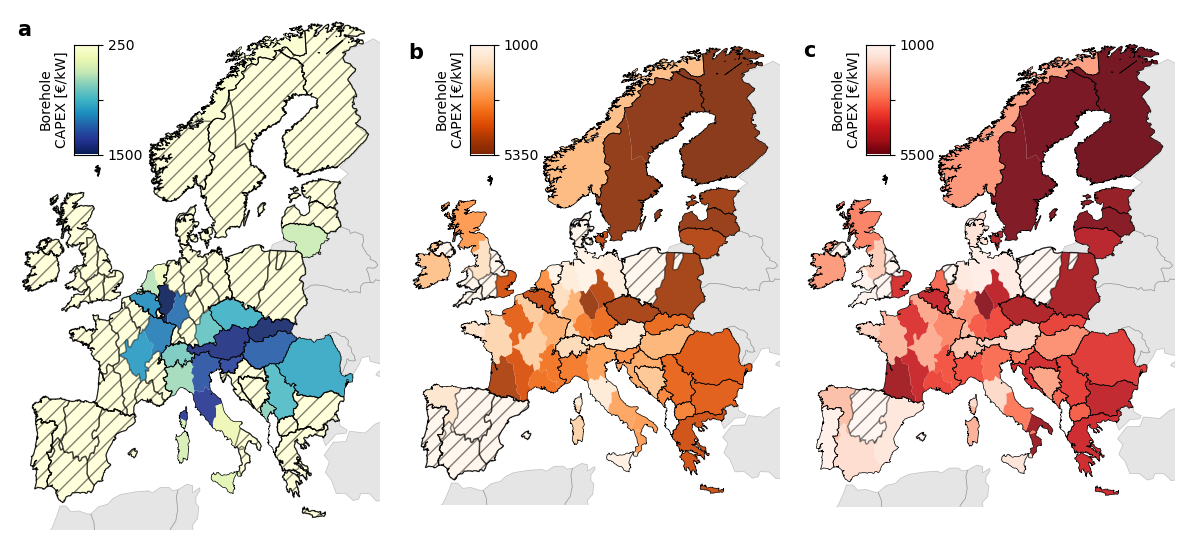

In [24]:
def plot_regions(col, ax, mode='capex', thresh=0.1, plot_nevers=False):

    assert col in ["elec", "chp", "dh"]

    color = colors[col]
    capex_threshold, year_threshold, ever = get_data(col)

    capex_threshold = capex_threshold[thresh]
    year_threshold = year_threshold[thresh]
    ever = ever[thresh]

    year_threshold = - (year_threshold - 2020) + 2050

    regions[col] = locals()[mode + "_threshold"]
    regions[col+'_ever'] = ever

    if mode == "year":
        vmin = 2020
        vmax = 2050

        if col == "elec":
            cmap = "YlGnBu"
        elif col == "dh":
            cmap = "Reds"
        elif col == "chp":
            cmap = "Oranges"

    elif mode == "capex":
        vmin = regions[col].min()
        vmax = regions[col].max()

        if col == "elec":
            cmap = "YlGnBu"
        elif col == "dh":
            cmap = "Reds"
        elif col == "chp":
            cmap = "Oranges"
    
    regions.plot(
        ax=ax,
        column=col,
        label=f"10%",
        cmap=cmap,
        alpha=0.9,
        )
    worldmap.loc[other_countries].plot(
        ax=ax,
        color="grey",
        edgecolor="black",
        alpha=0.2,
        linewidth=0.5,
        )
    countries.plot(
        ax=ax,
        color="none",
        edgecolor="black",
        linewidth=0.5,
        )
    
    if plot_nevers:
        
        regions.loc[regions[col+"_ever"] == "never"].plot(
            ax=ax,
            facecolor="none",
            edgecolor="k",
            hatch='//',
            alpha=0.5,
            )


    cax_lims = {
        "elec": [0.07, 0.71, 0.02, 0.2],
        "chp": [0.40, 0.71, 0.02, 0.2],
        "dh": [0.73, 0.71, 0.02, 0.2],
    }

    cax = fig.add_axes(cax_lims.get(col, [0.35, 0.67, 0.02, 0.18]))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cax.set_xticks([])

    y = np.atleast_2d(np.linspace(vmin, vmax, 100)).T
    y = np.hstack((y, y))

    cax.imshow(y, aspect='auto', cmap=cmap)# , vmin=vmin, vmax=vmax)
    
    if mode == "capex":
        cax.set_ylabel("Borehole\nCAPEX [{}/kW]".format(u"\N{euro sign}"))
    elif mode == "year":
        cax.set_ylabel("Drilling Cost Relative\nto 2020 Level [%]")

    cax.yaxis.set_major_locator(plt.LinearLocator(numticks=3))
    if col == "elec" and mode == "capex":
        cax.set_yticklabels(["250", "", "1500"])
    elif col == "dh" and mode == "capex":
        cax.set_yticklabels(["1000", "", "5500"])
    elif col == "chp" and mode == "capex":
        cax.set_yticklabels(["1000", "", "5350"])
    elif mode == "year":
        cax.set_yticklabels(["20", "40", "100"])
    else:
        print(cax.get_yticklabels())
        print(regions[col].min())
        print(regions[col].max())

    cax.yaxis.set_ticks_position("right")

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    ax.set_xlim(-12, 33)
    ax.set_ylim(34, 72)

fig, axs = plt.subplots(1, 3, figsize=(12, 5.5))


###    mode 'year' for main text figure, mode `capex` for appendix figure

mode = 'capex'
# mode = 'year'
thresh = 0.1

plot_regions("elec", axs[0], mode=mode, thresh=thresh, plot_nevers=True)
plot_regions("chp", axs[1], mode=mode, thresh=thresh, plot_nevers=True)
plot_regions("dh", axs[2], mode=mode, thresh=thresh, plot_nevers=True)

for ax, label in zip(axs.flatten(), ["a", "b", "c", "d"]):
    ax.text(0.02, 0.95, label, fontsize=15, weight="bold", transform=ax.transAxes)

plt.tight_layout()
plt.savefig(f"geothermal_maps_{mode}.pdf", bbox_inches="tight")
plt.show()

In [27]:
import pypsa

nfile = (
    root /
    "example_network.nc"
)

n = pypsa.Network(nfile)


INFO:pypsa.io:Imported network example_network.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [29]:
ss = (l := n.loads_t.p_set)[l.columns[l.columns.str.contains("urban central heat")]]
ss.columns = ss.columns.str[:5]

In [30]:
costs = n.links.loc[n.links.carrier == 'injection geothermal heat']['capital_cost']
costs.index = costs.index.str[:5]
costs = (costs - costs.min()) / (costs.max() - costs.min())

costs = costs.clip(0, 0.15)
costs = 1 - (costs - costs.min()) / (costs.max() - costs.min())

C:\Users\lukas\AppData\Local\Temp\ipykernel_32472\188451183.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels([str(int(vmin)), "", str(int(vmax))])
C:\Users\lukas\AppData\Local\Temp\ipykernel_32472\188451183.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(["Low", "", "High"])
C:\Users\lukas\AppData\Local\Temp\ipykernel_32472\188451183.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


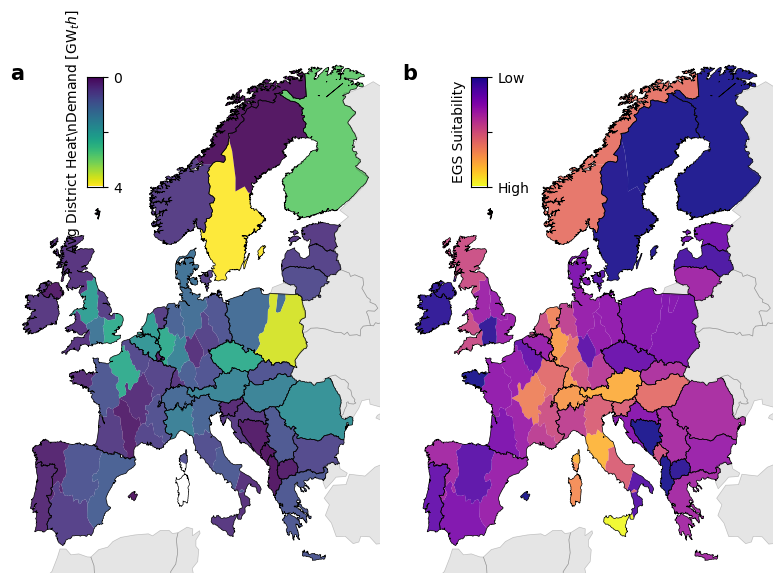

In [31]:
loads = regions[['geometry']]
loads = pd.concat((
    loads,
    ss.sum().rename('avg_district_heat_load') / 8760 * 180 * 1e-3,
    costs.rename('capex')
    ), axis=1)

fig, axs = plt.subplots(1, 2, figsize=(8, 5.5))

cax_lims = {
    "avg_district_heat_load": [0.12, 0.73, 0.02, 0.2],
    "capex": [0.6, 0.73, 0.02, 0.2],
}

for ax, col, cmap in zip(
    axs,
    ["avg_district_heat_load", "capex"],
    ['viridis', 'plasma']
    ):

    vmin = loads[col].min()
    vmax = loads[col].max()

    cax = fig.add_axes(cax_lims[col])
    cax.set_xticks([])

    y = np.atleast_2d(np.linspace(vmin, vmax, 100)).T
    y = np.hstack((y, y))

    cax.imshow(y, aspect='auto', cmap=cmap)

    cax.yaxis.set_major_locator(plt.LinearLocator(numticks=3))

    if col == "avg_district_heat_load":
        cax.set_yticklabels([str(int(vmin)), "", str(int(vmax))])
        cax.set_ylabel(r"Avg District Heat\nDemand [GW$_th$]")

    elif col == "capex":
        cax.set_yticklabels(["Low", "", "High"])
        cax.set_ylabel("EGS Suitability")

    cax.yaxis.set_ticks_position("right")

    loads.plot(
        ax=ax,
        column=col,
        label=f"10%",
        cmap=cmap,
        alpha=0.9,
        )
    worldmap.loc[other_countries].plot(
        ax=ax,
        color="grey",
        edgecolor="black",
        alpha=0.2,
        linewidth=0.5,
        )
    countries.plot(
        ax=ax,
        color="none",
        edgecolor="black",
        linewidth=0.5,
        )


for ax, label in zip(axs.flatten(), ["a", "b", "c", "d"]):
    ax.text(0.0, 0.95, label, fontsize=15, weight="bold", transform=ax.transAxes)

for ax in axs:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    ax.set_xlim(-12, 33)
    ax.set_ylim(34, 72)

plt.tight_layout()
plt.savefig(f"dh_demand_and_suitability.pdf", bbox_inches="tight")
plt.show()

In [32]:
n.generators.carrier.unique()


for carrier in ['onwind', 'offwind-ac', 'solar']:
    g = n.generators.loc[n.generators.carrier == carrier].index
    cap = n.generators_t.p_max_pu[g].mean()

    cap.index = cap.index.str[:5]

    regions[carrier] = np.nan
    regions.loc[cap.index, carrier] = cap


In [33]:
import matplotlib.colors as mcolors


def get_cmap(other):

    colors = ['#FFFFFF', other]

    n_bins = 100
    cm = mcolors.LinearSegmentedColormap.from_list(other, colors, N=n_bins)

    return cm

In [34]:
nice_carrier_names = {
    'onwind': 'Onshore Wind',
    'offwind-ac': 'Offshore Wind',
    'solar': 'Solar PV',
}

C:\Users\lukas\AppData\Local\Temp\ipykernel_32472\745575923.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(["7%", "", "18%"])
C:\Users\lukas\AppData\Local\Temp\ipykernel_32472\745575923.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(["3%", "", "43%"])
C:\Users\lukas\AppData\Local\Temp\ipykernel_32472\745575923.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels(["9%", "", "48%"])
C:\Users\lukas\AppData\Local\Temp\ipykernel_32472\745575923.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


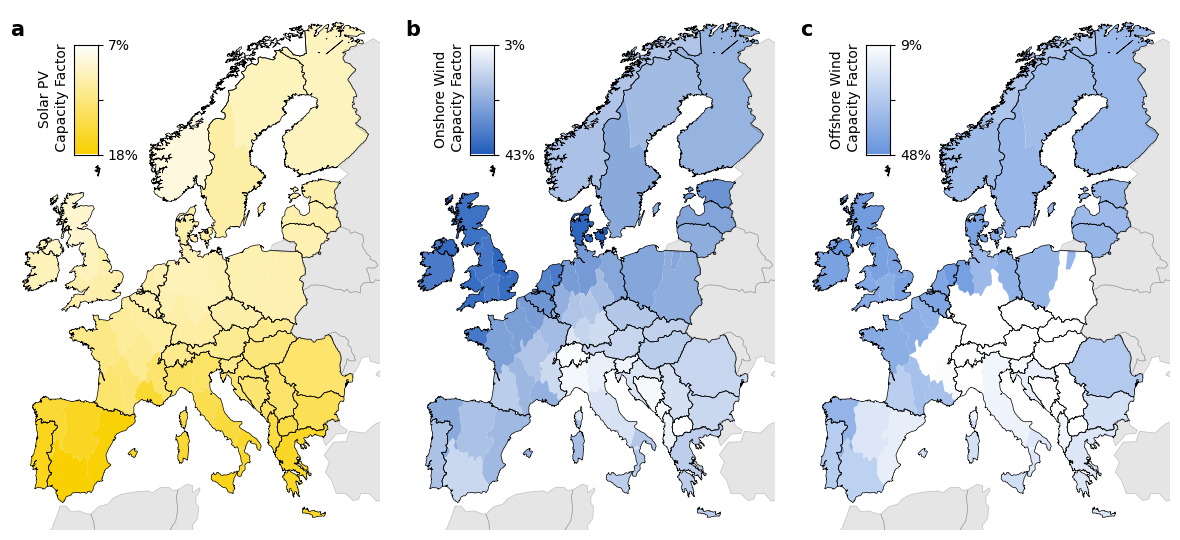

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5.5))

cax_lims = {
    "solar": [0.07, 0.71, 0.02, 0.2],
    "onwind": [0.40, 0.71, 0.02, 0.2],
    "offwind-ac": [0.73, 0.71, 0.02, 0.2],
}

for ax, (carrier, cax_lim), c in zip(axs, cax_lims.items(), ['#f9d002', '#235ebc', '#6895dd']):

    vmin = regions[carrier].min()
    vmax = regions[carrier].max()

    cax = fig.add_axes(cax_lim)
    cax.set_xticks([])

    y = np.atleast_2d(np.linspace(vmin, vmax, 100)).T
    y = np.hstack((y, y))

    cmap = get_cmap(c)
    cax.imshow(y, aspect='auto', cmap=cmap)# , vmin=vmin, vmax=vmax)

    cax.yaxis.set_major_locator(plt.LinearLocator(numticks=3))

    if carrier == "solar":
        cax.set_yticklabels(["7%", "", "18%"])

    if carrier == "onwind":
        cax.set_yticklabels(["3%", "", "43%"])

    if carrier == "offwind-ac":
        cax.set_yticklabels(["9%", "", "48%"])
    
    cax.set_ylabel(f"{nice_carrier_names[carrier]}\n Capacity Factor")

    cax.yaxis.set_ticks_position("right")

    regions.plot(
        ax=ax,
        column=carrier,
        # label=f"10%",
        cmap=cmap,
        # alpha=0.9,
        )
    worldmap.loc[other_countries].plot(
        ax=ax,
        color="grey",
        edgecolor="black",
        alpha=0.2,
        linewidth=0.5,
        )
    countries.plot(
        ax=ax,
        color="none",
        edgecolor="black",
        linewidth=0.5,
        )


for ax, label in zip(axs.flatten(), ["a", "b", "c", "d"]):
    ax.text(0.0, 0.95, label, fontsize=15, weight="bold", transform=ax.transAxes)

for ax in axs:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    ax.set_xlim(-12, 33)
    ax.set_ylim(34, 72)

plt.tight_layout()
plt.savefig("capacity_factors.pdf", bbox_inches="tight")
plt.show()

In [36]:
idx = pd.IndexSlice

caps = pd.read_csv(
    root / 
    "joint_data" /
    "nodal_capacities.csv", 
    index_col=[0,1,2], 
    header=[0,1,2,3,4,5,6,7,8],
    ).sort_index().loc[idx[:,:,"injection geothermal heat"], idx[:,:,:,:,['2035', '2050'],:,'static',:,:]]
caps.index = caps.index.get_level_values(1)
caps.columns = caps.columns.droplevel([0,1,2,3,6,7,8])

In [37]:
caps

egs_capex         2035                                     2050               \
egs_mode           chp           dh          elec           chp           dh   
AL1 0         0.000469     0.000360      0.000309      0.000555     0.000380   
AT1 0      5602.594137  2756.403791  96002.157843  99541.977610  2877.834551   
BA1 0       178.261132   160.872822      0.001787    292.959314   190.328391   
BE1 0      3175.073733  2313.841533      0.005895   8808.448771  3234.375611   
BG1 0      1325.200079  1178.624236      0.004480   2602.035033  1313.980498   
...                ...          ...           ...           ...          ...   
RS1 0      1856.694020  1596.259144      0.005031   3648.024132  1803.734296   
SE2 0      6360.509489  6037.617203      0.002118   7294.062431  7169.524764   
SE2 1        35.545587    35.333343      0.002046     38.006634    36.229426   
SI1 0       598.994578   444.388336      0.011618   3003.906728   448.776256   
SK1 0      1446.602232  1195.765699      0.005890   7017.398914  1419.972401   

egs_capex                 
egs_mode            elec  
AL1 0           0.000274  
AT1 0      189275.314249  
BA1 0           0.004507  
BE1 0       78929.409898  
BG1 0           0.081462  
...                  ...  
RS1 0       16729.286799  
SE2 0           0.007132  
SE2 1           0.006371  
SI1 0       17674.828651  
SK1 0       36167.841884  

[72 rows x 6 columns]

In [38]:
from itertools import product

allcaps = regions.copy()

cax_lims = {
    "elec": [0.07, 0.71, 0.02, 0.2],
    "chp": [0.40, 0.71, 0.02, 0.2],
    "dh": [0.73, 0.71, 0.02, 0.2],
}

for year, app in product(['2035', '2050'], cax_lims.keys()):

    allcaps[f'capacities_{year}_{app}'] = caps.loc[:,idx[year,app]]

allcaps.index = range(1, 73)

C:\Users\lukas\AppData\Local\Temp\ipykernel_32472\4239109424.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(allcaps.geometry.centroid.x, allcaps.geometry.centroid.y, allcaps.index):


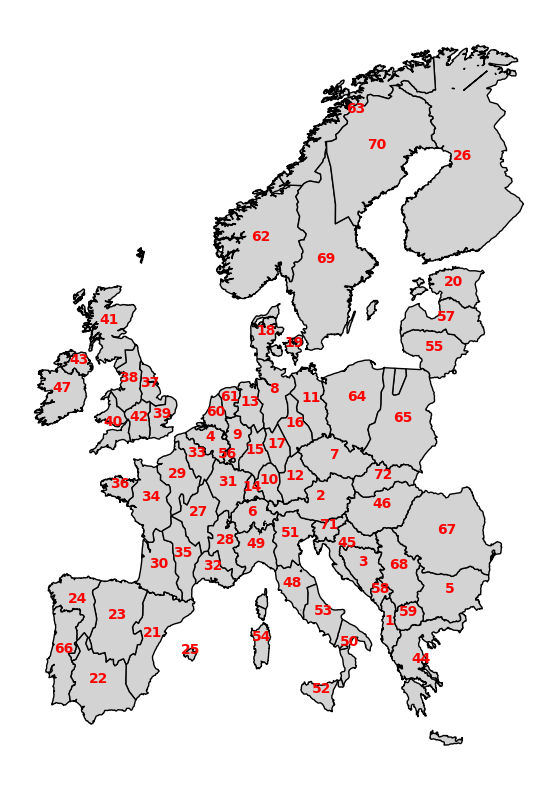

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

allcaps.plot(ax=ax, color='lightgray', edgecolor='black')

for x, y, label in zip(allcaps.geometry.centroid.x, allcaps.geometry.centroid.y, allcaps.index):
    ax.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0,0),
        ha='center',
        color='red',
        weight='bold'
        )

ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig("numbered_regions.pdf", bbox_inches="tight")
plt.show()

In [40]:
nice_names = {
    "elec": "Electricity Only",
    "chp": "Combined Low-Grade Heat and Power",
    "dh": "Low-Grade Heat Only",
}

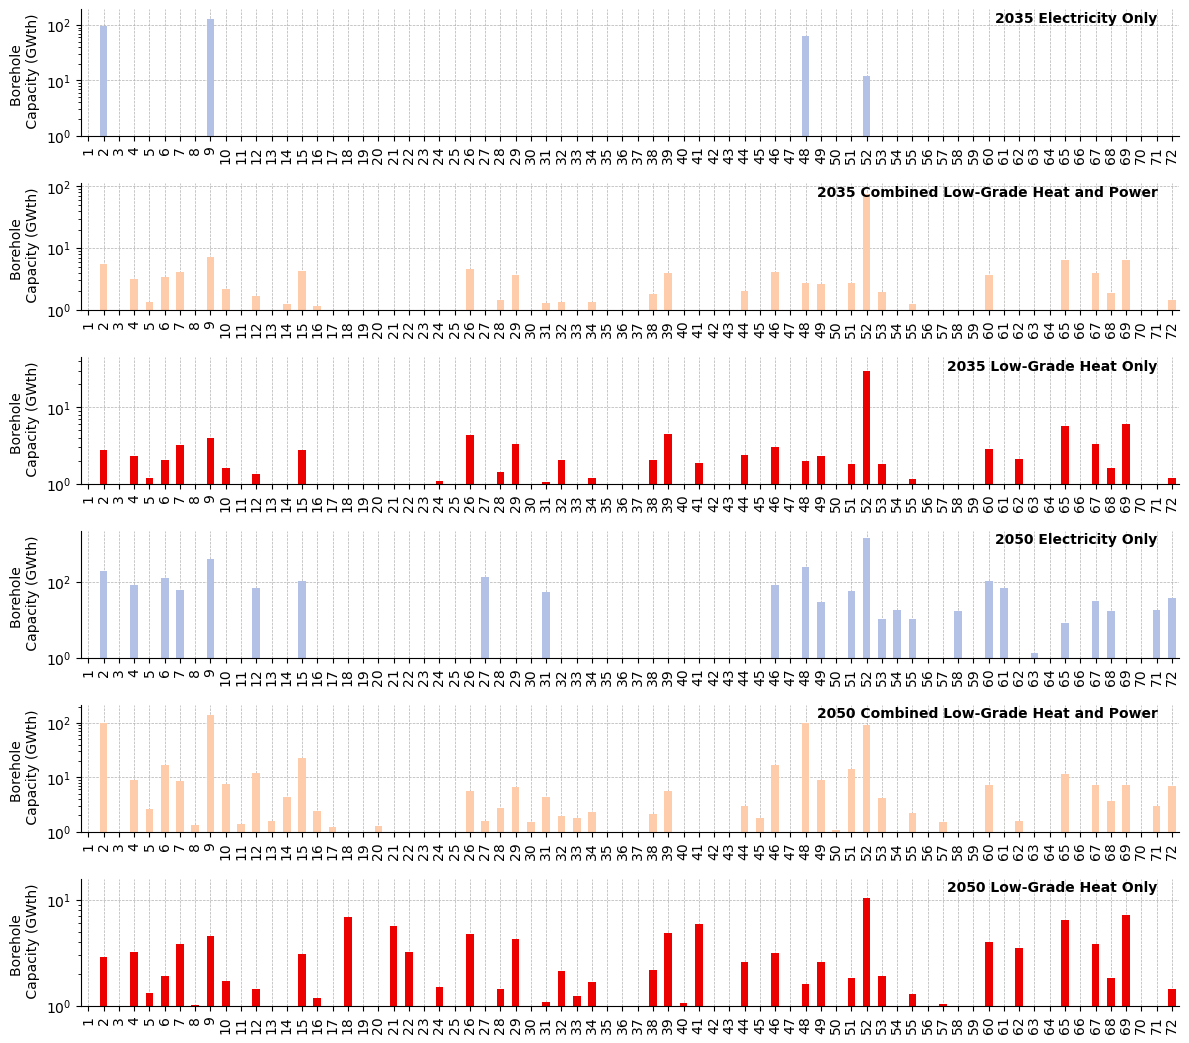

In [41]:
fig = plt.figure(figsize=(12, 12))

for i, (year, app) in enumerate(product(['2035', '2050'], cax_lims.keys())):
    ax = fig.add_subplot(7, 1, i+1)
    column = f'capacities_{year}_{app}'
    col = allcaps[column].mul(1e-3)
    col.plot.bar(ax=ax, color=colors[app])
    ax.set_yscale('log')
    ax.set_ylim(1, col.max()*1.5)
    
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', colors='k')
    ax.tick_params(axis='y', colors='k')
    
    if i == 6:
        ax.set_xlabel('Regions')
    
    ax.set_ylabel('Borehole \n Capacity (GWth)')
    ax.text(
        0.98,
        0.9,
        f'{year} {nice_names[app]}',
        ha='right',
        fontsize=10,
        transform=ax.transAxes,
        fontweight='bold'
        )
    
plt.tight_layout()
plt.savefig("all_borehole_capacities.pdf", bbox_inches="tight")
plt.show()

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
ss = []

for year in np.arange(2025, 2055, 5, dtype=int):

    df = pd.read_csv(
        Path.cwd() / "egs_cost_data" / "egs_costs_s_72_{}.csv".format(year)
        ).set_index("name")[['capex_mean']].rename(columns={'capex_mean': year})
    ss.append(df)

pd.concat(ss, axis=1)

,2025,2030,2035,2040,2045,2050
name,,,,,,
AL1 0,NaN,NaN,NaN,NaN,NaN,NaN
AT1 0,1978.614086,1529.991367,1107.520773,807.055099,636.202388,558.441477
BA1 0,4517.922904,3493.547878,2528.888025,1842.811462,1452.690225,1275.132709
BE1 0,3230.065582,2497.693962,1808.015396,1317.508511,1038.593353,911.649527
BG1 0,3208.490760,2481.010926,1795.938982,1308.708376,1031.656198,905.560277
...,...,...,...,...,...,...
RS1 0,3099.610548,2396.817760,1734.993749,1264.297326,996.646920,874.830067
SE2 0,3938.197354,3045.266885,2204.389127,1606.347735,1266.285619,1111.511721
SE2 1,3991.064151,3086.146885,2233.981091,1627.911524,1283.284377,1126.432777
